# The AR6 Shared Socioeconomic Pathway Effective Radiative Forcing Timeseries, 1750-2500

In [1]:
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as st
import random
import pandas as pd
from tqdm.notebook import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species

import matplotlib.pyplot as pl
import json

In [2]:
forcing = {}

check_and_download(
    '../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv'
)

check_and_download(
    '../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv',
    'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-concentrations-annual-means-v5-1-0.csv'
)
    
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
scenarios = ['ssp119','ssp126','ssp245','ssp370','ssp370-lowNTCF-gidden','ssp370-lowNTCF-aerchemmip','ssp434','ssp460','ssp534-over','ssp585']
for scenario in scenarios:
    forcing[scenario] = {}

In [4]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total['NMVOC']
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update
#new_ceds

emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
new_emissions = {}
for scenario in tqdm(scenarios):
    bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    oc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|OC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    so2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|Sulfur'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nh3 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NH3'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    nmvoc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|VOC'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    co = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    bc[:265] = emissions_ceds_update.loc[1750:2014,'BC'].values
    oc[:265] = emissions_ceds_update.loc[1750:2014,'OC'].values
    so2[:265] = emissions_ceds_update.loc[1750:2014,'SO2'].values
    nh3[:265] = emissions_ceds_update.loc[1750:2014,'NH3'].values
    nox[:265] = emissions_ceds_update.loc[1750:2014,'NOx'].values
    nmvoc[:265] = emissions_ceds_update.loc[1750:2014,'VOC'].values
    co[:265] = emissions_ceds_update.loc[1750:2014,'CO'].values
    bc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'BC'].values + np.linspace(0,0.8,5) * bc[265:270]
    oc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'OC'].values + np.linspace(0,0.8,5) * oc[265:270]
    so2[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'SO2'].values + np.linspace(0,0.8,5) * so2[265:270]
    nh3[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NH3'].values + np.linspace(0,0.8,5) * nh3[265:270]
    nox[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NOx'].values + np.linspace(0,0.8,5) * nox[265:270]
    nmvoc[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'VOC'].values + np.linspace(0,0.8,5) * nmvoc[265:270]
    co[265:270] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO'].values + np.linspace(0,0.8,5) * co[265:270]
    
    new_emissions[scenario] = pd.DataFrame(
    {
        'BC': bc,
        'OC': oc,
        'SO2': so2,
        'NH3': nh3,
        'NOx': nox,
        'VOC': nmvoc,
        'CO': co
    })

(250.0, 280.0)

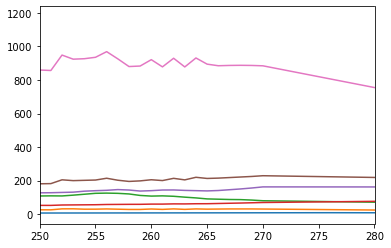

In [5]:
pl.plot(new_emissions['ssp585'])
pl.xlim(250,280)

## Solar radiation

In [6]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_erf = np.zeros((751))
solar_erf[:550] = df.solar_erf.loc[1750:2299].values
for scenario in scenarios:
    forcing[scenario]['solar']=solar_erf

## Volcanic forcing

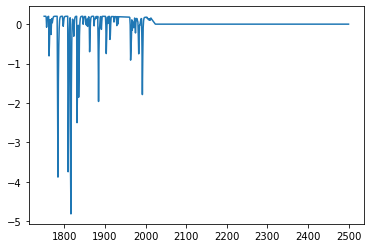

In [7]:
df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_erf = np.zeros((751))
volcanic_erf[:265] = df.volcanic_erf.loc[1750:2014].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_erf[264:275] = volcanic_erf[264] * np.linspace(1,0,11)
volcanic_erf[275:] = 0.
pl.plot(np.arange(1750,2501), volcanic_erf[:])
#emissions = np.loadtxt('../data/SSP460_INTERIM_EMISSIONS.csv', skiprows=3, delimiter=',')

for scenario in scenarios:
    forcing[scenario]['volcanic']=volcanic_erf

## Aerosol forcing

In [8]:
df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

samples = 25000
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.65/NINETY_TO_ONESIGMA, size=samples, random_state=31318990)

ERFari = np.zeros((270,samples))
ERFaci = np.zeros((270,samples))
    
bc = emissions_ceds_update['BC'].values.squeeze()
oc = emissions_ceds_update['OC'].values.squeeze()
so2 = emissions_ceds_update['SO2'].values.squeeze()
nh3 = emissions_ceds_update['NH3'].values.squeeze()

for i in tqdm(range(samples), leave=False):
    ts2010 = np.mean(
        ghan(
            [
                so2[255:265],
                    bc[255:265]+
                    oc[255:265],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
    )
    ts1750 = ghan(
        [
            so2[0],
                bc[0]+
                oc[0],
        ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
    )
    ERFaci[:,i] = (
        ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
    - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

In [9]:
# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.70/NINETY_TO_ONESIGMA, size=samples)

array([-2.06740653, -1.75794166, -1.30075506, -0.83401531, -0.53122743])

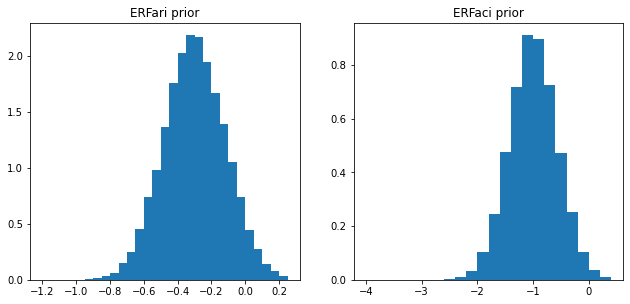

In [10]:
fig,ax = pl.subplots(1,2, figsize=(27/2.54,12/2.54))
ax[0].hist(ERFari_scale, bins=np.arange(-1.2,0.3,0.05), density=True);
ax[0].set_title('ERFari prior');
ax[1].hist(ERFaci_scale, bins=np.arange(-4,0.5,0.2), density=True);
ax[1].set_title('ERFaci prior');
np.percentile(ERFari_scale+ERFaci_scale, (5,16,50,84,95))

In [11]:
ERFari = {}
ERFaci = {}

bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[97])
nh3_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nh3 = nh3_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

for scenario in tqdm(scenarios):
    ERFari[scenario] = np.zeros((751,samples))
    ERFaci[scenario] = np.zeros((751,samples))
    
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    
    for i in tqdm(range(samples), leave=False):
        ERFari[scenario][:, i] = (
            (so2-so2[0]) * beta_so2[i] +
            (bc-bc[0]) * beta_bc[i] +
            (oc-oc[0]) * beta_oc[i] +
            (nh3-nh3[0]) * beta_nh3[i]
        )
    
    for i in tqdm(range(samples), leave=False):

        ts2010 = np.mean(
            ghan(
                [
                    so2[255:265],
                        bc[255:265]+
                        oc[255:265],
                ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
            )
        )
        ts1750 = ghan(
            [
                so2[0],
                    bc[0]+
                    oc[0],
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1]
        )
        ERFaci[scenario][:,i] = (
            ghan([so2, bc+oc], 1.11, aci_coeffs[i,0], aci_coeffs[i,1])
        - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

In [12]:
ERFari_median = {}
ERFaci_median = {}

for scenario in tqdm(scenarios):
    bc = new_emissions[scenario]['BC'].values.squeeze()
    oc = new_emissions[scenario]['OC'].values.squeeze()
    so2 = new_emissions[scenario]['SO2'].values.squeeze()
    nh3 = new_emissions[scenario]['NH3'].values.squeeze()
    
    beta_bc = 0.3/(np.mean(bc[255:265])-bc[0])
    beta_oc = -0.09/(np.mean(oc[255:265])-oc[0])
    beta_so2 = -0.4/(np.mean(so2[255:265])-so2[0])
    beta_nh3 = -0.11/(np.mean(nh3[255:265])-nh3[0])
    ERFaci_median[scenario] = np.percentile(ERFaci[scenario], 50, axis=1) * (-1.0)/(np.percentile(ERFaci[scenario], 50, axis=1)[255:265].mean())
    ERFari_median[scenario] = (
        (so2-so2[0]) * beta_so2 +
        (bc-bc[0]) * beta_bc +
        (oc-oc[0]) * beta_oc +
        (nh3-nh3[0]) * beta_nh3
    )

In [13]:
for scenario in tqdm(scenarios):   
    forcing[scenario]['aerosol-radiation_interactions'] = ERFari_median[scenario]
    forcing[scenario]['aerosol-cloud_interactions'] = ERFaci_median[scenario]

## BC on snow

Linear with emissions, 2019 = 0.08 in the historical from AR6

In [14]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/BC_global_CEDS_emissions_by_sector_2020_09_11.csv')
bc_hist = df.loc[:,'X1750':'X2019'].sum(axis=0).values/1000.

df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
bc_ar6_forc = df.loc[:,'bc_on_snow']

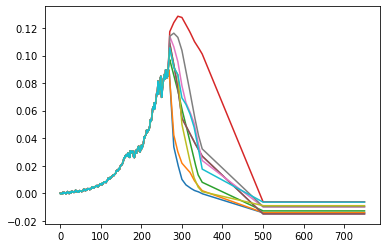

In [15]:
for scenario in scenarios:
    bc = new_emissions[scenario]['BC'].values.squeeze()
    forcing[scenario]['bc_on_snow'] = (bc-bc[0])/(bc_hist[264]-bc_hist[0])*bc_ar6_forc[264]
    pl.plot(forcing[scenario]['bc_on_snow'])

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

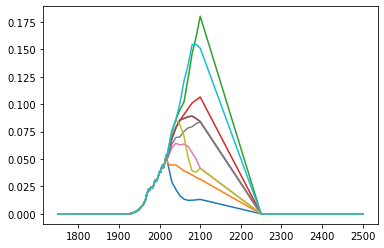

In [16]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/NOx_global_CEDS_emissions_by_sector_2020_09_11.csv')
avi_nox_hist = df[df.sector.str.endswith("aviation")].loc[:,'X1750':'X2019'].sum(axis=0).values/1000.
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
bc_ar6_forc = df.loc[:,'contrails']
for scenario in scenarios:
    avi_nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|NOx|MAGICC Fossil and Industrial|Aircraft'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze()
    avi_nox[:265] = avi_nox_hist[:265]
    avi_nox[265:270] = np.linspace(1,0.2,5) * avi_nox_hist[265:270] + np.linspace(0,0.8,5) * avi_nox[265:270]
    contrail_forcing_2014 = bc_ar6_forc[264]
    forcing[scenario]['contrails'] = avi_nox/avi_nox_hist[264] * contrail_forcing_2014
    pl.plot(np.arange(1750,2501), forcing[scenario]['contrails'])

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add --0.05 for irrigation

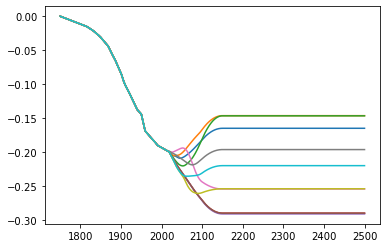

In [17]:
ghimire = pd.read_csv('../data_input/ghimire_curve_fit.csv')
for scenario in scenarios:
    lusf2019 = -0.20/np.cumsum(emissions.loc[(emissions['Scenario']=='ssp245')&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values.squeeze())[269]  # include irrigation of -0.05 in Sherwood et al
    forcing[scenario]['land_use'] = np.cumsum(emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2500'].interpolate(axis=1, pad=True).values.squeeze())*lusf2019
    f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
    lusf2019 = -0.20/(f(2019)-f(1750))
    forcing[scenario]['land_use'][:269] = lusf2019*(f(np.arange(1750,2019))-f(1750))
    pl.plot(np.arange(1750, 2501), forcing[scenario]['land_use'])

## Greenhouse gas concentrations

For consistency I will use the observations for GHGs to 2019, and then ramp to SSPs in 2029.

**TODO** what are we doing about +5% in non-CO2 gases?

**TODO** use Meinshausen forcing relationship?

In [18]:
ghg_obs = pd.read_excel('../data_input/LLGHG_history_AR6_v8a.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
gases_obs = ghg_obs.columns.to_list()
gases_obs.remove('YYYY')
print(*(gases_obs))

gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

CO2 CH4 N2O HFC-134a HFC-23 HFC-32 HFC-125 HFC-143a HFC-152a HFC-227ea HFC-236fa HFC-245fa HFC-365mfc HFC-43-10mee NF3 SF6 SO2F2 CF4 C2F6 C3F8 c-C4F8 CFC-12 CFC-11 CFC-113 CFC-114 CFC-115 CFC-13 HCFC-22 HCFC-141b HCFC-142b CH3CCl3 CCl4 CH3Cl CH3Br CH2Cl2 CHCl3 Halon-1211 Halon-1301 Halon-2402 n-C4F10 n-C5F12 n-C6F14 i-C6F14 C7F16 C8F18 CFC-112 CFC-112a CFC-113a CFC-114a HCFC-133a HCFC-31 HCFC-124


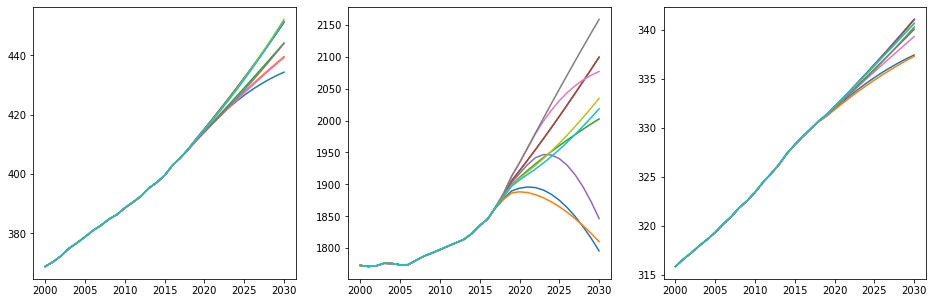

In [19]:
fig, ax = pl.subplots(1,3,figsize=(16,5))
for scenario in tqdm(scenarios):
    forcing[scenario]['co2'] = np.zeros(751)
    forcing[scenario]['ch4'] = np.zeros(751)
    forcing[scenario]['n2o'] = np.zeros(751)

    co2 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CO2')),'1750':'2500'].values.squeeze()
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2500'].values.squeeze()
    co2[:265] = ghg_obs['CO2'].values[:265]
    ch4[:265] = ghg_obs['CH4'].values[:265]
    n2o[:265] = ghg_obs['N2O'].values[:265]
    
    co2[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CO2'].values[264:270] + np.linspace(0,1,6) * co2[264:270]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    n2o[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['N2O'].values[264:270] + np.linspace(0,1,6) * n2o[264:270]
    
    for i, year in enumerate(range(1750,2501)):
        forcing[scenario]['co2'][i], forcing[scenario]['ch4'][i], forcing[scenario]['n2o'][i] = meinshausen( #etminan(
            [co2[i], ch4[i], n2o[i]], 
            [co2[0], ch4[0], n2o[0]], scale_F2x=False)

    # include rapid adjustments for CO2, CH4 and N2O:
    forcing[scenario]['co2'] = 1.05 * forcing[scenario]['co2']
    forcing[scenario]['ch4'] = 0.86 * forcing[scenario]['ch4']
    forcing[scenario]['n2o'] = 1.07 * forcing[scenario]['n2o']
    
    ax[0].plot(np.arange(2000,2031), co2[250:281])
    ax[1].plot(np.arange(2000,2031),ch4[250:281])
    ax[2].plot(np.arange(2000,2031),n2o[250:281])

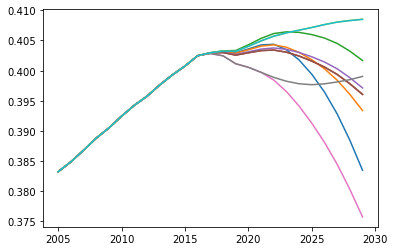

In [20]:
gases=['CO2','CH4','N2O',
     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
     'Halon1301','Halon2402']

radeff = {
    'HFC-125':      0.23378,
    'HFC-134a':     0.16714,
    'HFC-143a':     0.168,
    'HFC-152a':     0.10174,
    'HFC-227ea':    0.27325,
    'HFC-23':       0.19111,
    'HFC-236fa':    0.25069,
    'HFC-245fa':    0.24498,
    'HFC-32':       0.11144,
    'HFC-365mfc':   0.22813,
    'HFC-43-10mee': 0.35731,
    'NF3':          0.20448,
    'C2F6':         0.26105,
    'C3F8':         0.26999,
    'n-C4F10':      0.36874,
    'n-C5F12':      0.4076,
    'n-C6F14':      0.44888,
    'i-C6F14':      0.44888, 
    'C7F16':        0.50312,
    'C8F18':        0.55787,
    'CF4':          0.09859,
    'c-C4F8':       0.31392,
    'SF6':          0.56657,
    'SO2F2':        0.21074,
    'CCl4':         0.16616,
    'CFC-11':       0.25941,
    'CFC-112':      0.28192,  
    'CFC-112a':     0.24564, 
    'CFC-113':      0.30142,
    'CFC-113a':     0.24094,  
    'CFC-114':      0.31433,
    'CFC-114a':     0.29747, 
    'CFC-115':      0.24625,
    'CFC-12':       0.31998,
    'CFC-13':       0.27752,
    'CH2Cl2':       0.02882,
    'CH3Br':        0.00432,
    'CH3CCl3':      0.06454,
    'CH3Cl':        0.00466,
    'CHCl3':        0.07357,
    'HCFC-124':     0.20721,
    'HCFC-133a':    0.14995,
    'HCFC-141b':    0.16065,
    'HCFC-142b':    0.19329,
    'HCFC-22':      0.21385,
    'HCFC-31':      0.068,
    'Halon-1211':   0.30014,
    'Halon-1301':   0.29943,
    'Halon-2402':   0.31169,
}

trop_adjustment_scale = radeff.copy()
for key in trop_adjustment_scale.keys():
    trop_adjustment_scale[key] = 1
trop_adjustment_scale['CFC-11'] = 1.13
trop_adjustment_scale['CFC-12'] = 1.12

for scenario in scenarios:
    forcing[scenario]['other_wmghg'] = np.zeros(751)
    for gas in gases_obs[3:]:
        meins = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(ghg_to_rcmip_names[gas])),'1750':'2500'].values.squeeze()
        if meins.shape == (0,751):
            meins = np.zeros(751)
        obs = ghg_obs[gas].values[:270]
        conc = np.zeros(751)
        conc[:265] = obs[:265]
        conc[264:270] = np.linspace(1.0,0.0,6) * obs[264:270] + np.linspace(0,1,6) * meins[264:270]
        conc[270:] = meins[270:]
        forcing[scenario][gas] = ((conc - conc[0]) * radeff[gas] * 0.001) * trop_adjustment_scale[gas]
        forcing[scenario]['other_wmghg'] = forcing[scenario]['other_wmghg'] + forcing[scenario][gas]
    pl.plot(np.arange(2005,2030), forcing[scenario]['other_wmghg'][255:280])

## Tropospheric ozone

Follow Skeie (AR6) for 1750-2014, then use emissions-based relationships based on Stevenson et al. **TODO** coefficients from AerChemMIP

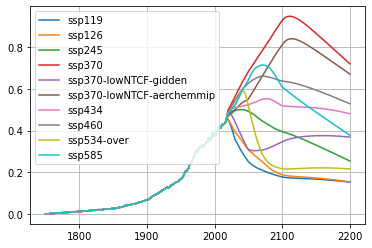

In [21]:
for scenario in tqdm(scenarios):
    ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
    ch4[:265] = ghg_obs['CH4'].values[:265]
    ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
    n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2500'].values.squeeze()
    n2o[:265] = ghg_obs['N2O'].values[:265]
    n2o[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['N2O'].values[264:270] + np.linspace(0,1,6) * n2o[264:270]
    ods = np.zeros((751))
    for specie in ods_species:
        this_ods = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith(specie)),'1750':'2500'].values.squeeze()
        this_ods[:265] = ghg_obs.loc[:2014,rcmip_to_ghg_names[specie]].values.squeeze()
        this_ods[264:270] = np.linspace(1.0,0.0,6) * ghg_obs.loc[2014:2019,rcmip_to_ghg_names[specie]].values.squeeze() + np.linspace(0,1,6) * this_ods[264:270]
        ods = ods + (eesc(this_ods, specie))
    co = new_emissions[scenario]['CO']
    nox = new_emissions[scenario]['NOx']
    voc = new_emissions[scenario]['VOC']
    
    ozone_rad_eff = {
        'CH4' : 2.17806958e-04,
        'N2O' : 1.08675131e-03,
        'ODS' : -5.99546209e-05,
        'CO' : 7.00793760e-05,
        'VOC' : -4.92424155e-05,
        'NOx' : 1.29886170e-03
    }

    forcing[scenario]['o3'] = (
        ozone_rad_eff['CH4'] * (ch4-ch4[0]) +
        ozone_rad_eff['N2O'] * (n2o-n2o[0]) +
        ozone_rad_eff['ODS'] * (ods-ods[0]) +
        ozone_rad_eff['CO'] * (co-co[0]) +
        ozone_rad_eff['VOC'] * (voc-voc[0]) +
        ozone_rad_eff['NOx'] * (nox-nox[0])
    ).values
    pl.plot(np.arange(1750,2201), forcing[scenario]['o3'][:451], label=scenario)
pl.grid()
pl.legend()

In [22]:
### DON'T DELETE THIS CELL YET ###

# good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
# skeie_trop = pd.read_csv('../data_input/skeie_ozone_trop.csv', index_col=0)
# skeie_trop = skeie_trop.loc[good_models]
# skeie_trop.insert(0, 1850, 0)
# skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
# skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
# skeie_trop.insert(0, 1750, -0.03)
# skeie_trop_post2010 = skeie_trop.loc['OsloCTM3',[2014,2017,2020]]-skeie_trop.loc['OsloCTM3', 2010]
# skeie_trop.loc[:,[2014,2017,2020]] = skeie_trop.loc[:,2010:2010].values + skeie_trop_post2010.values[None,:]
# skeie_trop = skeie_trop + 0.03
# f = interp1d(skeie_trop.columns, skeie_trop.mean(), bounds_error=False, fill_value='extrapolate')
# years = np.arange(1750,2020)
# o3tr = f(years)

# for scenario in tqdm_notebook(scenarios):
#     ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
#     ch4[:265] = ghg_obs['CH4'].values[:265]
#     ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
#     co = new_emissions[scenario]['CO']
#     nox = new_emissions[scenario]['NOx']
#     voc = new_emissions[scenario]['VOC']

#     delta_Eco = co[255:265].mean() - co[100:109].mean()
#     delta_Enox = nox[255:265].mean() - nox[100:109].mean()
#     delta_Evoc = voc[255:265].mean() - voc[100:109].mean()
#     delta_Cch4 = ch4[255:265].mean() - ch4[100:109].mean()

#     # radiative efficiencies in W/m2/Mt - numbers for W/m2 from Stevenson
#     radeff_ch4 = 0.166/delta_Cch4
#     radeff_co  = 0.055/delta_Eco
#     radeff_nox = 0.119/delta_Enox
#     radeff_voc = 0.035/delta_Evoc

#     fac_cmip6_skeie = (
#         (
#         radeff_ch4 * delta_Cch4 +
#         radeff_co  * delta_Eco +
#         radeff_nox * delta_Enox +
#         radeff_voc * delta_Evoc
#         ) / (o3tr[260]-o3tr[100])
#     )
#     ts = np.vstack((ch4, co, nox, voc)).T

#     def fit_stevenson(x, rch4, rco, rnox, rvoc):
#         return rch4*x[0] + rco*x[1] + rnox*x[2] + rvoc*x[3]

#     p, cov = curve_fit(
#         fit_stevenson, 
#         ts[100:261,:].T - ts[100:261, :].T,
#         o3tr[100:261],
#         bounds=((0.120/delta_Cch4/fac_cmip6_skeie, 0.045/delta_Eco/fac_cmip6_skeie, 0.086/delta_Enox/fac_cmip6_skeie, 0.035/delta_Evoc/fac_cmip6_skeie),
#                 (0.212/delta_Cch4/fac_cmip6_skeie, 0.071/delta_Eco/fac_cmip6_skeie, 0.152/delta_Enox/fac_cmip6_skeie, 0.053/delta_Evoc/fac_cmip6_skeie))
#     )

#     forcing[scenario]['o3_tropospheric'] = np.zeros((751))
#     forcing[scenario]['o3_tropospheric'][:265] = o3tr[:265]
#     forcing[scenario]['o3_tropospheric'][265:] = (
#         p[0] * (ch4[265:] - ch4[0]) +
#         p[1] * (co[265:]  - co[0]) +
#         p[2] * (nox[265:]  - nox[0])+
#         p[3] * (voc[265:]  - voc[0])
#     )# + o3tr[264]

#     pl.plot(np.arange(1750,2201), forcing[scenario]['o3_tropospheric'][:451])

In [23]:
# good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
# skeie_strat = pd.read_csv('../data_input/skeie_ozone_strat.csv', index_col=0)
# skeie_strat = skeie_strat.loc[good_models]
# skeie_strat.insert(0, 1850, 0)
# skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
# skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
# skeie_strat.insert(0, 1750, 0)
# skeie_strat_post2010 = skeie_strat.loc['OsloCTM3',[2014,2017,2020]]-skeie_strat.loc['OsloCTM3', 2010]
# skeie_strat.loc[:,[2014,2017,2020]] = skeie_strat.loc[:,2010:2010].values + skeie_strat_post2010.values[None,:]
# f = interp1d(skeie_strat.columns, skeie_strat.mean(), bounds_error=False, fill_value='extrapolate')
# years = np.arange(1750,2020)
# o3st = f(years)

# for scenario in tqdm_notebook(scenarios):
#     ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2500'].values.squeeze()
#     ch4[:265] = ghg_obs['CH4'].values[:265]
#     ch4[264:270] = np.linspace(1.0,0.0,6) * ghg_obs['CH4'].values[264:270] + np.linspace(0,1,6) * ch4[264:270]
#     co = new_emissions[scenario]['CO']
#     nox = new_emissions[scenario]['NOx']
#     voc = new_emissions[scenario]['VOC']
    
#     delta_Eco = co[255:265].mean() - co[100:109].mean()
#     delta_Enox = nox[255:265].mean() - nox[100:109].mean()
#     delta_Evoc = voc[255:265].mean() - voc[100:109].mean()
#     delta_Cch4 = ch4[255:265].mean() - ch4[100:109].mean()

#     # radiative efficiencies in W/m2/Mt - numbers for W/m2 from Stevenson
#     radeff_ch4 = 0.166/delta_Cch4
#     radeff_co  = 0.055/delta_Eco
#     radeff_nox = 0.119/delta_Enox
#     radeff_voc = 0.035/delta_Evoc

#     fac_cmip6_skeie = (
#         (
#         radeff_ch4 * delta_Cch4 +
#         radeff_co  * delta_Eco +
#         radeff_nox * delta_Enox +
#         radeff_voc * delta_Evoc
#         ) / (o3tr[260]-o3tr[100])
#     )
#     ts = np.vstack((ch4, co, nox, voc)).T

#     def fit_stevenson(x, rch4, rco, rnox, rvoc):
#         return rch4*x[0] + rco*x[1] + rnox*x[2] + rvoc*x[3]

#     p, cov = curve_fit(
#         fit_stevenson, 
#         ts[100:261,:].T - ts[100:261, :].T,
#         o3tr[100:261],
#         bounds=((0.120/delta_Cch4/fac_cmip6_skeie, 0.045/delta_Eco/fac_cmip6_skeie, 0.086/delta_Enox/fac_cmip6_skeie, 0.035/delta_Evoc/fac_cmip6_skeie),
#                 (0.212/delta_Cch4/fac_cmip6_skeie, 0.071/delta_Eco/fac_cmip6_skeie, 0.152/delta_Enox/fac_cmip6_skeie, 0.053/delta_Evoc/fac_cmip6_skeie))
#     )

#     forcing[scenario]['o3_stratospheric'] = np.zeros((751))
#     forcing[scenario]['o3_stratospheric'][:265] = o3st[:265]
#     forcing[scenario]['o3_stratospheric'][265:] = skeie_strat.mean()[2014]/skeie_trop.mean()[2014]*(
#         p[0] * (ch4[265:] - ch4[0]) +
#         p[1] * (co[265:]  - co[0]) +
#         p[2] * (nox[265:]  - nox[0])+
#         p[3] * (voc[265:]  - voc[0])
#     )# + o3tr[264]

#     pl.plot(np.arange(1750,2201), forcing[scenario]['o3_stratospheric'][:451])

## Stratospheric water vapour

In [24]:
forcing_ar6 = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')

for scenario in scenarios:
    forcing[scenario]['h2o_stratospheric'] = forcing[scenario]['ch4']/(forcing_ar6['ch4'].values[269] - forcing_ar6['ch4'].values[0]) * 0.05

In [25]:
colors = {
    'ssp119': '#1e9583',
    'ssp126': '#1d3354',
    'ssp245': '#e9dc3d',  # WHY is ssp245 yellow? This infuriates me
    'ssp370': '#f11111',
    'ssp370-lowNTCF-gidden': '#f11111', 
    'ssp370-lowNTCF-aerchemmip': '#f11111',
    'ssp434': '#63bce4',
    'ssp460': '#e78731',
    'ssp534-over': '#996dc8',
    'ssp585': '#830b22',
}

ls = {
    'ssp119': '-',
    'ssp126': '-',
    'ssp245': '-', 
    'ssp370': '-',
    'ssp370-lowNTCF-gidden': '--', 
    'ssp370-lowNTCF-aerchemmip': '-.',
    'ssp434': '-',
    'ssp460': '-',
    'ssp534-over': '-',
    'ssp585': '-',
}

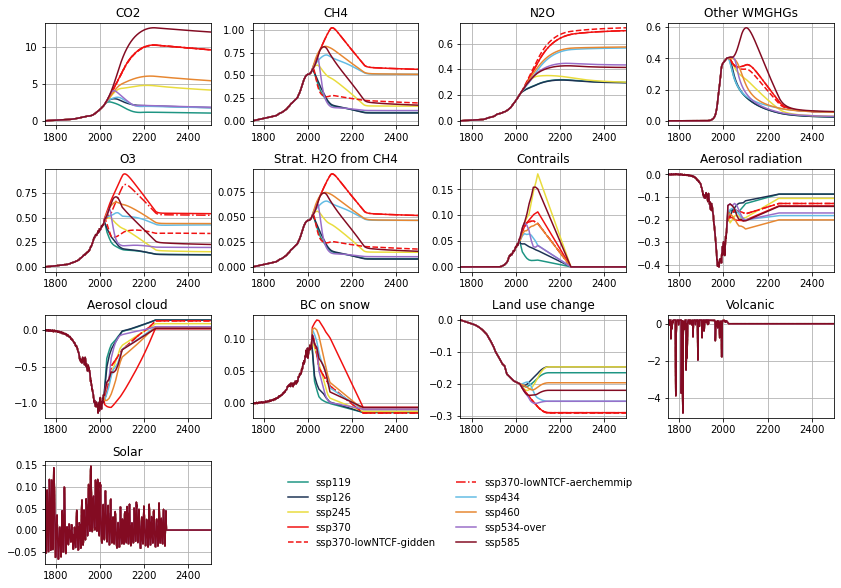

In [26]:
# solar forcing will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(29.7/2.54,21/2.54),squeeze=True)
for scenario in scenarios:
    ax[0,0].plot(np.arange(1750,2501),forcing[scenario]['co2'], color=colors[scenario], ls=ls[scenario])
    ax[0,1].plot(np.arange(1750,2501),forcing[scenario]['ch4'], color=colors[scenario], ls=ls[scenario])
    ax[0,2].plot(np.arange(1750,2501),forcing[scenario]['n2o'], color=colors[scenario], ls=ls[scenario])
    ax[0,3].plot(np.arange(1750,2501),forcing[scenario]['other_wmghg'], color=colors[scenario], ls=ls[scenario])
    ax[1,0].plot(np.arange(1750,2501),forcing[scenario]['o3'], color=colors[scenario], ls=ls[scenario])
    ax[1,1].plot(np.arange(1750,2501),forcing[scenario]['h2o_stratospheric'], color=colors[scenario], ls=ls[scenario])
    ax[1,2].plot(np.arange(1750,2501),forcing[scenario]['contrails'], color=colors[scenario], ls=ls[scenario])
    ax[1,3].plot(np.arange(1750,2501),forcing[scenario]['aerosol-radiation_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,0].plot(np.arange(1750,2501),forcing[scenario]['aerosol-cloud_interactions'], color=colors[scenario], ls=ls[scenario])
    ax[2,1].plot(np.arange(1750,2501),forcing[scenario]['bc_on_snow'], color=colors[scenario], ls=ls[scenario])
    ax[2,2].plot(np.arange(1750,2501),forcing[scenario]['land_use'], color=colors[scenario], ls=ls[scenario])
    ax[2,3].plot(np.arange(1750,2501),forcing[scenario]['volcanic'], color=colors[scenario], ls=ls[scenario])
    ax[3,0].plot(np.arange(1750,2501),forcing[scenario]['solar'], color=colors[scenario], ls=ls[scenario], label=scenario)

ax[3,1].axis('off')
ax[3,2].axis('off')
ax[3,3].axis('off')
#ax.set_xticks(np.arange(1750,2501,50))
ax[0,0].set_xlim(1750,2500)
ax[0,1].set_xlim(1750,2500)
ax[0,2].set_xlim(1750,2500)
ax[0,3].set_xlim(1750,2500)
ax[1,0].set_xlim(1750,2500)
ax[1,1].set_xlim(1750,2500)
ax[1,2].set_xlim(1750,2500)
ax[1,3].set_xlim(1750,2500)
ax[2,0].set_xlim(1750,2500)
ax[2,1].set_xlim(1750,2500)
ax[2,2].set_xlim(1750,2500)
ax[2,3].set_xlim(1750,2500)
ax[3,0].set_xlim(1750,2500)
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[0,3].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
ax[1,3].grid()
ax[2,0].grid()
ax[2,1].grid()
ax[2,2].grid()
ax[2,3].grid()
ax[3,0].grid()
ax[0,0].set_title('CO2')
ax[0,1].set_title('CH4')
ax[0,2].set_title('N2O')
ax[0,3].set_title('Other WMGHGs')
ax[1,0].set_title('O3')
ax[1,1].set_title('Strat. H2O from CH4')
ax[1,2].set_title('Contrails')
ax[1,3].set_title('Aerosol radiation')
ax[2,0].set_title('Aerosol cloud')
ax[2,1].set_title('BC on snow')
ax[2,2].set_title('Land use change')
ax[2,3].set_title('Volcanic')
ax[3,0].set_title('Solar')
pl.tight_layout()
ax[3,0].legend(bbox_to_anchor=[3.6,0.5], frameon=False, ncol=2, loc='center right')
#pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/components.png')

In [27]:
for scenario in scenarios:
    forcing[scenario]['total_anthropogenic']=forcing[scenario]['co2']+forcing[scenario]['ch4']+forcing[scenario]['n2o']+\
        forcing[scenario]['other_wmghg']+\
        forcing[scenario]['o3']+forcing[scenario]['h2o_stratospheric']+forcing[scenario]['contrails']+\
        forcing[scenario]['aerosol-radiation_interactions']+forcing[scenario]['aerosol-cloud_interactions']+forcing[scenario]['bc_on_snow']+forcing[scenario]['land_use']
    forcing[scenario]['total_natural']=forcing[scenario]['volcanic']+forcing[scenario]['solar']
    forcing[scenario]['total']=forcing[scenario]['total_anthropogenic']+forcing[scenario]['total_natural']

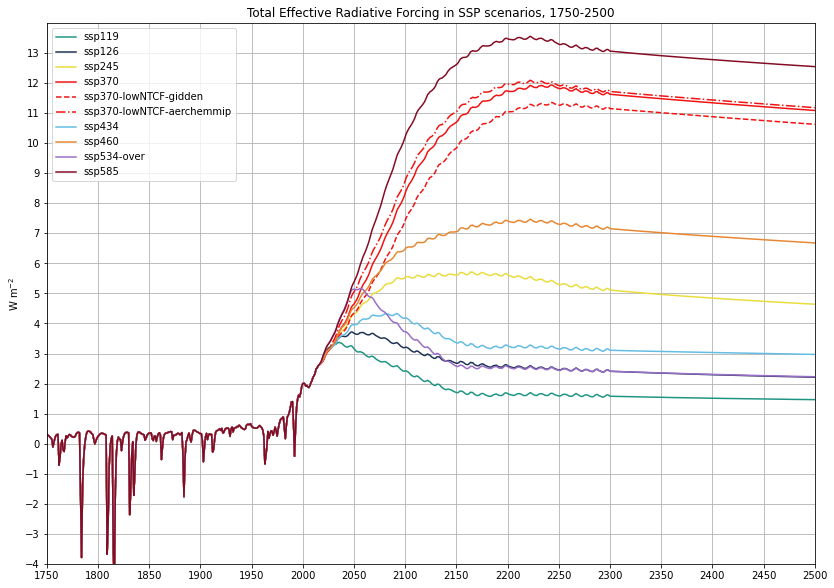

In [28]:
pl.figure(figsize=(29.7/2.54,21/2.54))
for scenario in scenarios:
    pl.plot(np.arange(1750,2501), forcing[scenario]['total'], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.yticks(np.arange(-4,14))
pl.xticks(np.arange(1750,2501,50))
pl.ylim(-4,14)
pl.xlim(1750,2500)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1750-2500')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('/nfs/see-fs-02_users/mencsm/ssp_erf/total.png')

In [29]:
gases_obs[3:]

['HFC-134a',
 'HFC-23',
 'HFC-32',
 'HFC-125',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-365mfc',
 'HFC-43-10mee',
 'NF3',
 'SF6',
 'SO2F2',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'CFC-12',
 'CFC-11',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'CFC-13',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CH3CCl3',
 'CCl4',
 'CH3Cl',
 'CH3Br',
 'CH2Cl2',
 'CHCl3',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'n-C4F10',
 'n-C5F12',
 'n-C6F14',
 'i-C6F14',
 'C7F16',
 'C8F18',
 'CFC-112',
 'CFC-112a',
 'CFC-113a',
 'CFC-114a',
 'HCFC-133a',
 'HCFC-31',
 'HCFC-124']

In [30]:
mkdir_p('../data_output/SSPs/')

for scenario in scenarios:
    df = pd.DataFrame(data=forcing[scenario], index=np.arange(1750,2501))
    df.index.name='year'
    df=df[['co2','ch4','n2o','other_wmghg','o3','h2o_stratospheric','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
      'volcanic','solar','total_anthropogenic','total_natural','total']]
    outname = scenario
    if scenario=='ssp370-lowNTCF':
        outname='ssp370-lowNTCF-gidden'
    df.to_csv('../data_output/SSPs/ERF_%s_1750-2500.csv' % outname)#
    df = pd.DataFrame(data=forcing[scenario], index=np.arange(1750,2501))
    df.index.name='year'
    df=df[gases_obs[3:]]
    df.to_csv('../data_output/SSPs/ERF_%s_minorGHGs_1750-2500.csv' % outname)
df

,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
year,,,,,,,,,,,,,,,,,,,,,
1750,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1751,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1752,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1753,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1754,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.000416,-2.433726e-08,2.952618e-07,0.000037,0.0,2.031220e-08,0.000347,0.0,0.0,...,0.0,0.000134,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.000414,-2.433726e-08,2.816652e-07,0.000036,0.0,1.946884e-08,0.000345,0.0,0.0,...,0.0,0.000134,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.000411,-2.433726e-08,2.686974e-07,0.000035,0.0,1.865874e-08,0.000342,0.0,0.0,...,0.0,0.000134,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df.loc[2000:2020]

,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
year,,,,,,,,,,,,,,,,,,,,,
2000,0.002376,0.002900,0.000023,0.000344,0.000411,0.000160,0.000031,0.000005,3.674700e-06,0.000002,...,0.000017,0.000035,0.000035,0.000138,0.000018,0.000067,0.000307,0.000017,0.000002,0.000000
2001,0.002963,0.003032,0.000031,0.000436,0.000491,0.000185,0.000039,0.000007,1.469880e-06,0.000003,...,0.000000,0.000037,0.000037,0.000137,0.000018,0.000071,0.000307,0.000017,0.000002,0.000000
2002,0.003603,0.003162,0.000042,0.000537,0.000585,0.000222,0.000047,0.000008,7.349400e-07,0.000006,...,0.000000,0.000038,0.000040,0.000135,0.000017,0.000073,0.000306,0.000019,0.000002,0.000000
2003,0.004296,0.003299,0.000058,0.000658,0.000688,0.000264,0.000057,0.000010,1.004418e-05,0.000013,...,0.000000,0.000040,0.000042,0.000134,0.000017,0.000077,0.000304,0.000020,0.000002,0.000000
2004,0.005014,0.003461,0.000085,0.000787,0.000810,0.000319,0.000069,0.000011,3.699198e-05,0.000028,...,0.000000,0.000042,0.000043,0.000132,0.000016,0.000080,0.000306,0.000025,0.000003,0.000259
2005,0.005774,0.003643,0.000123,0.000927,0.000945,0.000376,0.000083,0.000013,8.598798e-05,0.000047,...,0.000000,0.000043,0.000045,0.000131,0.000016,0.000083,0.000311,0.000031,0.000003,0.000269
2006,0.006503,0.003844,0.000165,0.001084,0.001098,0.000444,0.000100,0.000015,1.479679e-04,0.000069,...,0.000000,0.000045,0.000045,0.000129,0.000016,0.000086,0.000306,0.000037,0.000003,0.000274
2007,0.007239,0.004018,0.000218,0.001285,0.001261,0.000520,0.000117,0.000016,2.045583e-04,0.000088,...,0.000000,0.000047,0.000047,0.000128,0.000016,0.000089,0.000305,0.000043,0.000004,0.000280
2008,0.007995,0.004177,0.000275,0.001518,0.001443,0.000580,0.000136,0.000018,2.520844e-04,0.000104,...,0.000000,0.000048,0.000047,0.000127,0.000016,0.000093,0.000308,0.000044,0.000005,0.000259


In [32]:
df.loc[2100]

HFC-134a        7.075773e-02
HFC-23          4.591035e-03
HFC-32          2.690074e-06
HFC-125         2.311624e-01
HFC-143a        1.253179e-01
HFC-152a        6.591548e-04
HFC-227ea       2.990557e-03
HFC-236fa       1.319481e-03
HFC-245fa       9.586411e-03
HFC-365mfc      9.709122e-04
HFC-43-10mee    1.362266e-04
NF3             2.589678e-03
SF6             2.465487e-02
SO2F2           6.966374e-04
CF4             9.317643e-03
C2F6            1.882436e-03
C3F8            3.206374e-04
c-C4F8          1.167308e-03
CFC-12          7.478945e-02
CFC-11          1.506162e-02
CFC-113         7.972052e-03
CFC-114         3.234047e-03
CFC-115         2.124441e-03
CFC-13          0.000000e+00
HCFC-22         1.144343e-04
HCFC-141b       1.544557e-04
HCFC-142b       9.144627e-05
CH3CCl3         0.000000e+00
CCl4            8.223095e-04
CH3Cl           1.322970e-04
CH3Br          -6.824912e-07
CH2Cl2          2.394723e-03
CHCl3           7.914099e-05
Halon-1211      9.861351e-06
Halon-1301    

In [33]:
df_obs = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv', index_col=0)
df_obs['total'].loc[1980:2026]

year
1980    0.844269
1981    0.893435
1982    0.515573
1983    0.170441
1984    0.612463
1985    0.899962
1986    0.954001
1987    1.057089
1988    1.229160
1989    1.394896
1990    1.400563
1991    0.645393
1992   -0.417060
1993    0.545949
1994    1.208324
1995    1.492058
1996    1.616184
1997    1.544455
1998    1.674369
1999    1.904755
2000    1.999064
2001    2.014261
2002    1.978015
2003    1.906146
2004    1.934639
2005    1.881357
2006    1.866881
2007    1.924627
2008    2.031063
2009    2.098579
2010    2.203945
2011    2.261418
2012    2.323614
2013    2.486073
2014    2.511923
2015    2.571550
2016    2.639426
2017    2.720752
2018    2.748052
2019    2.798214
Name: total, dtype: float64

In [34]:
pl.rcParams['font.size'] = 16

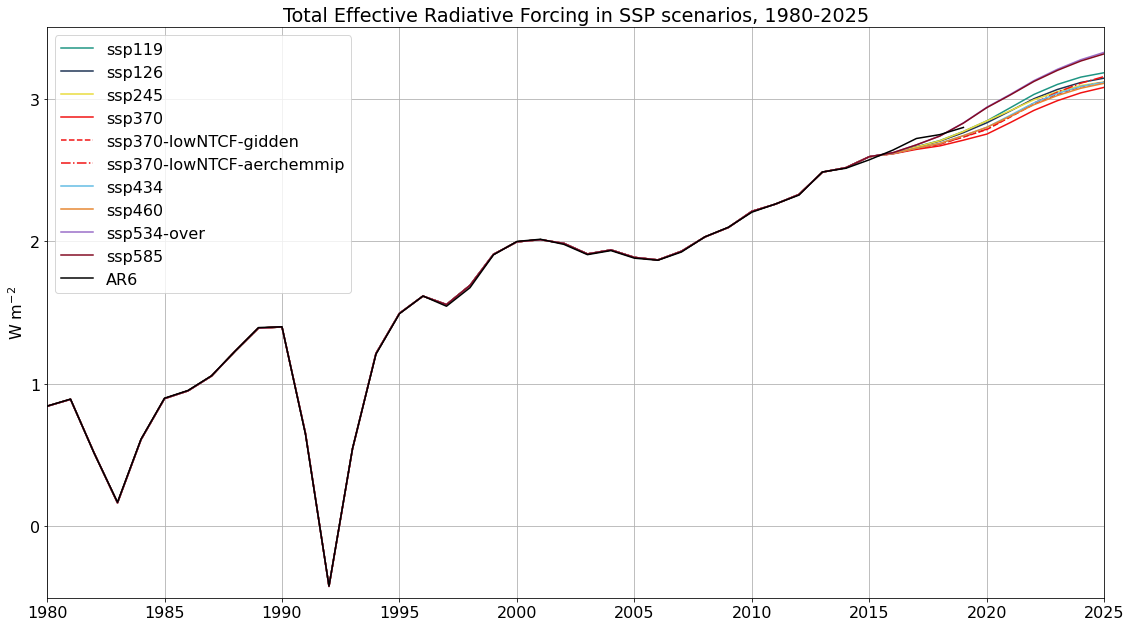

In [35]:
#pl.figure(figsize=(29.7/2.54,21/2.54))
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1980,2026), forcing[scenario]['total'][230:276], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1980,2020), df_obs['total'].loc[1980:2020], color='k', label='AR6')
pl.yticks(np.arange(-4,14))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-0.5,3.5)
pl.xlim(1980,2025)
pl.legend()
pl.grid()
pl.title('Total Effective Radiative Forcing in SSP scenarios, 1980-2025')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')

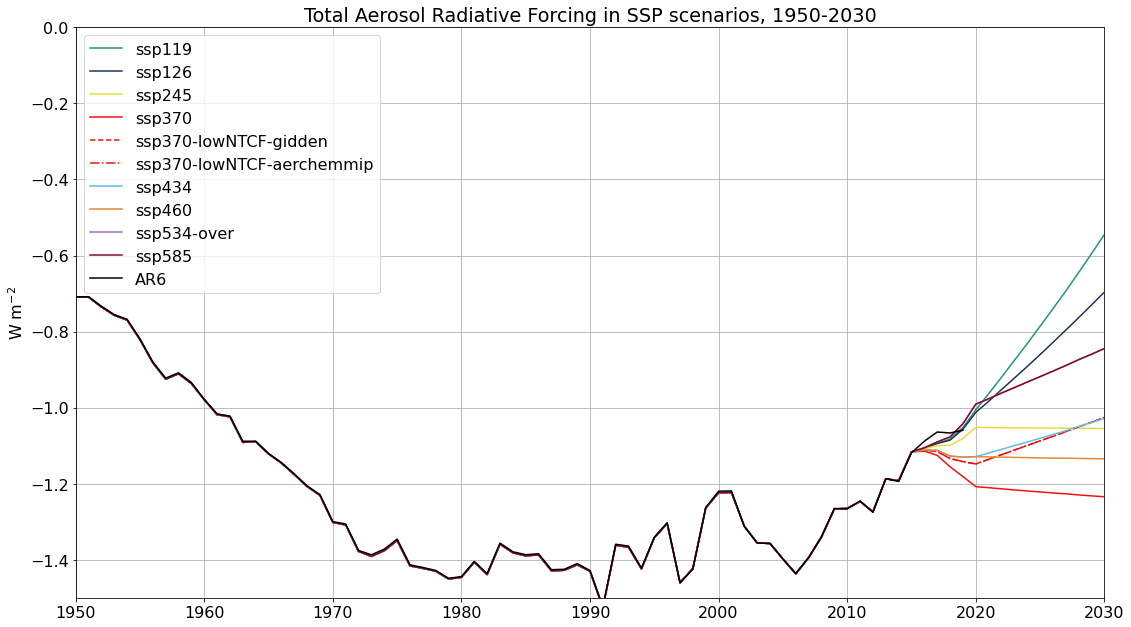

In [36]:
pl.figure(figsize=(16,9))
for scenario in scenarios:
    pl.plot(np.arange(1950,2031), forcing[scenario]['aerosol-radiation_interactions'][200:281]+forcing[scenario]['aerosol-cloud_interactions'][200:281], label=scenario, color=colors[scenario], ls=ls[scenario])
pl.plot(np.arange(1950,2020), df_obs['aerosol-radiation_interactions'].loc[1950:2020]+df_obs['aerosol-cloud_interactions'].loc[1950:2020], color='k', label='AR6')
#pl.yticks(np.arange(-1.5,0.25))
#pl.xticks(np.arange(1750,2501,50))
pl.ylim(-1.5,0)
pl.xlim(1950,2030)
pl.legend()
pl.grid()
pl.title('Total Aerosol Radiative Forcing in SSP scenarios, 1950-2030')
pl.ylabel('W m$^{-2}$')
pl.tight_layout()
#pl.savefig('../plots/total_1980-2025.png')